In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

os.environ["CUDA_VISIBLE_DEVICES"]="1"



Using TensorFlow backend.


In [2]:
BaseDir = '/run/media/sancere/DATA/Lucas_NextonCreated_npz/'
ModelName = 'SpinwideFRAP4_Training_CARE_40x_bin1_3Kate'

load_path = BaseDir + ModelName + '.npz'

(X,Y), (X_val,Y_val), axes = load_training_data(load_path, validation_split=0.1, verbose=True)
c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 165888
number of validation images:	 18432
image size (3D):		 (16, 64, 64)
axes:				 SZYXC
channels in / out:		 1 / 1


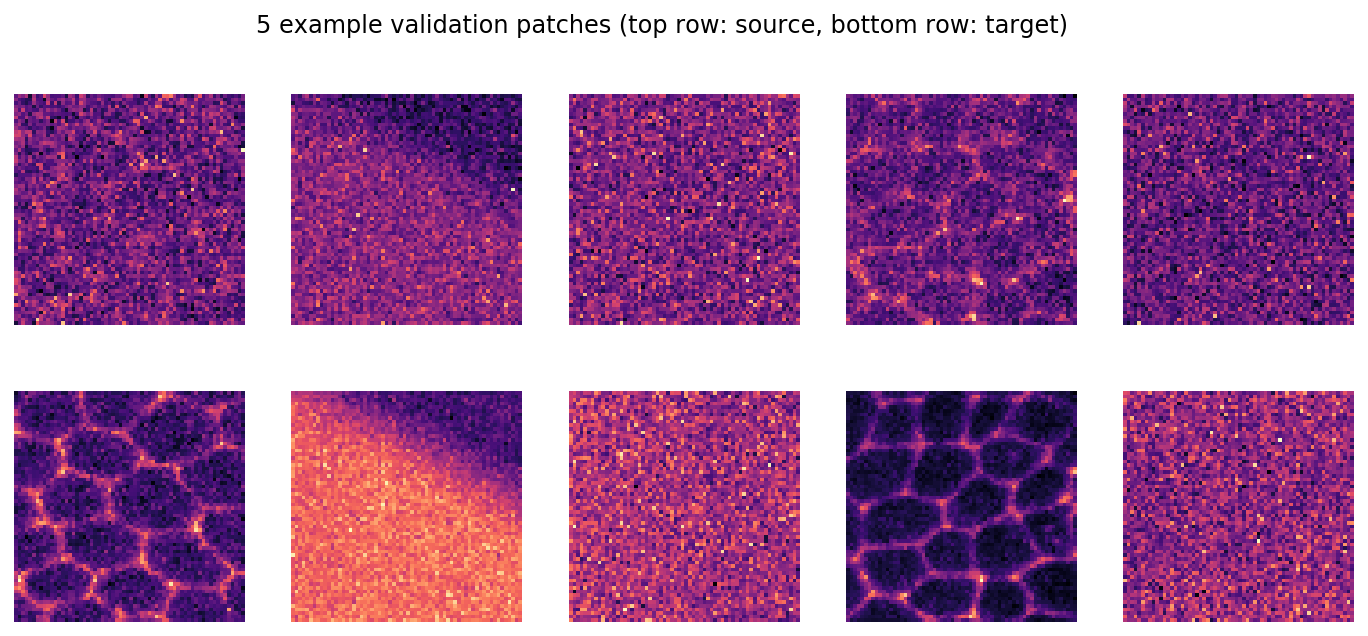

In [3]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [4]:
config = Config(axes, n_channel_in, n_channel_out, unet_n_depth=4,train_epochs= 100,train_steps_per_epoch = 400, train_batch_size = 16, train_reduce_lr={'patience': 5, 'factor': 0.5})
print(config)
vars(config)

Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'patience': 5, 'factor': 0.5}, train_steps_per_epoch=400, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=4, unet_n_first=32, unet_residual=True)


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 4,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'patience': 5, 'factor': 0.5}}

In [5]:
model = CARE(config = config, name = ModelName, basedir = BaseDir)

In [6]:
history = model.train(X,Y, validation_data=(X_val,Y_val))










The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/100
400/400 [==============================] - 187s 468ms/step - loss: 0.0850 - mse: 0.0123 - mae: 0.0850 - val_loss: 0.0770 - val_mse: 0.0100 - val_mae: 0.0770

Epoch 2/100
400/400 [==============================] - 186s 465ms/step - loss: 0.0774 - mse: 0.0100 - mae: 0.0774 - val_loss: 0.0770 - val_mse: 0.0099 - val_mae: 0.0770
Epoch 3/100
400/400 [==============================] - 190s 476ms/step - loss: 0.0760 - mse: 0.0095 - mae: 0.0760 - val_loss: 0.0750 - val_mse: 0.0093 - val_mae: 0.0750
Epoch 4/100
400/400 [==============================] - 186s 466ms/step - loss: 0.0747 - mse: 0.0092 - mae: 0.0747 - 

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


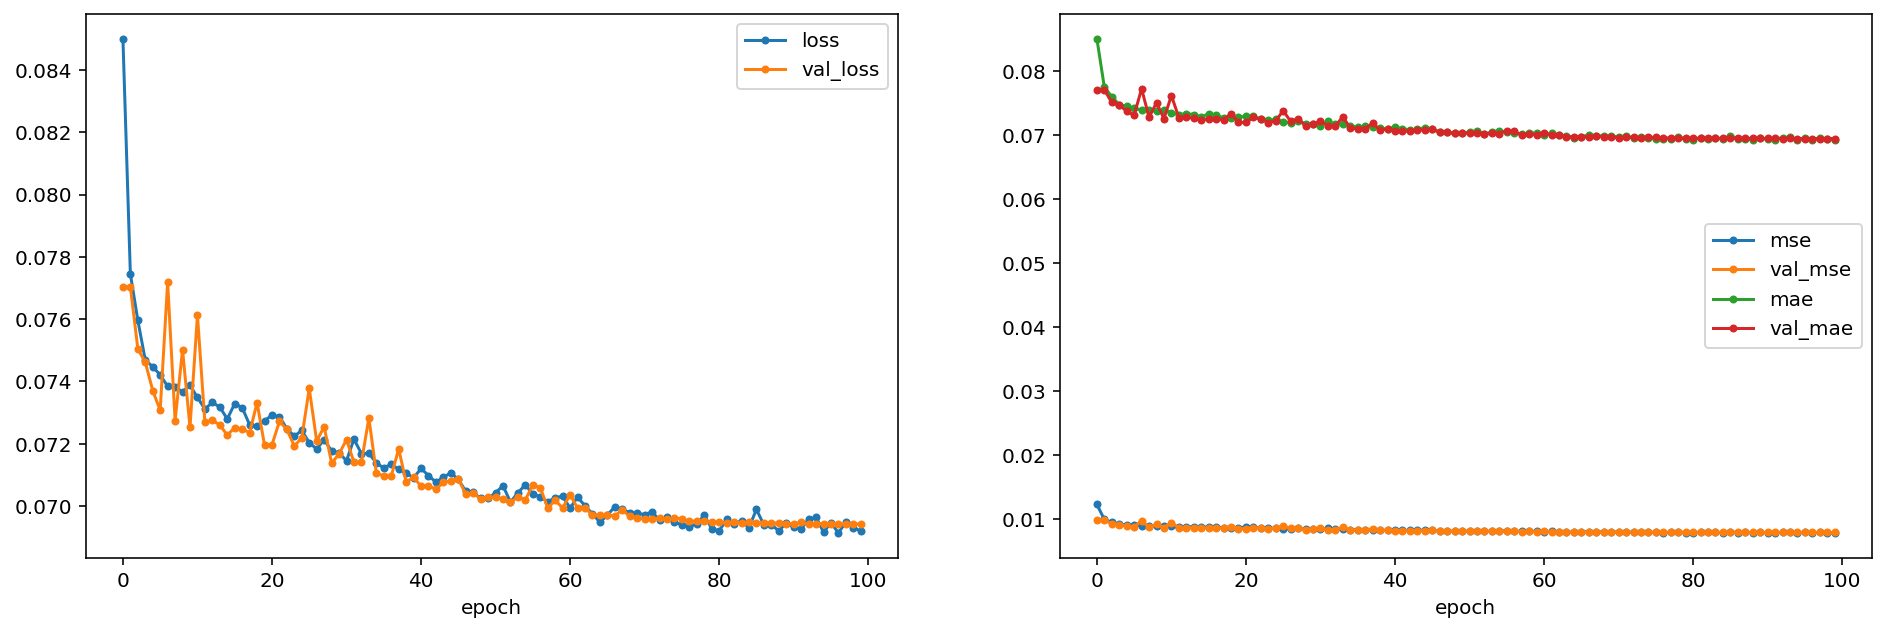

In [7]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

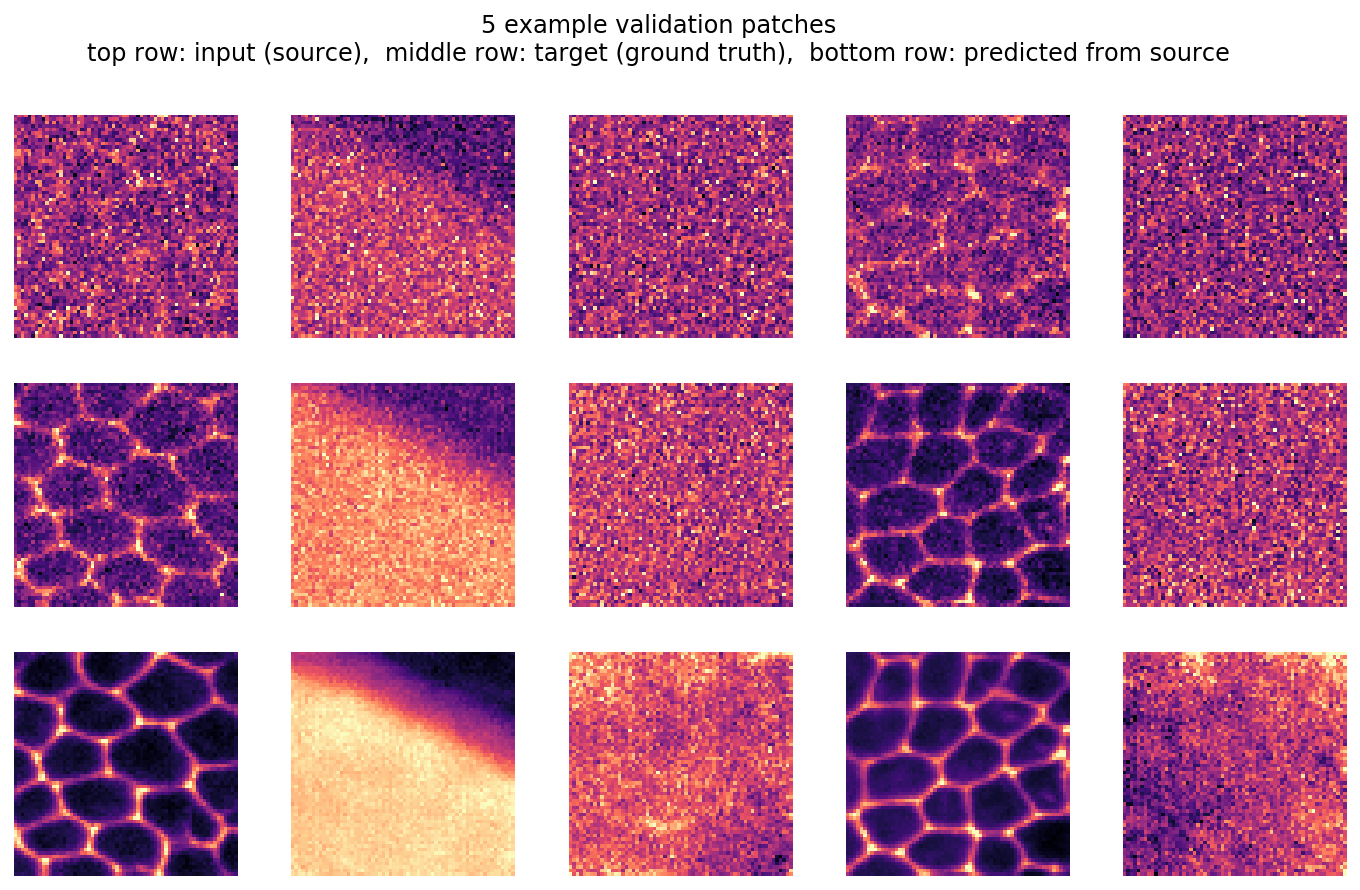

In [8]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
     _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
              'top row: input (source),  '          
              'middle row: target (ground truth),  '
              'bottom row: predicted from source');

In [9]:
model.export_TF()



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmp79957xid/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/run/media/sancere/DATA/Lucas_NextonCreated_npz/SpinwideFRAP4_Training_CARE_40x_bin1_3Kate/TF_SavedModel.zip
